# Determining Optimal Stop-Loss Thresholds via Bayesian Analysis of Drawdown Distributions - <br> `Antoine E. Zambelli` 

#### Objectives:
    1. Propose a systematic method to select stop-loss thresholds based on the distribution of maximum drawdowns.
    2. Aim to maximize expected returns using available information.
    3. Present results for an hourly trading strategy with two variations on the construction.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import yfinance as yf 

plt.style.use('seaborn-v0_8-darkgrid') 
import warnings
warnings.filterwarnings('ignore') 

In [10]:
start_date = '2022-10-17'
end_date = '2023-07-22' 
amt = 100000 

tickers = ['SPY', 'IWM'] 

In [16]:
data = pd.DataFrame() 
data = yf.download(tickers, period='5d', interval='1m')['Adj Close']  

[*********************100%%**********************]  2 of 2 completed


In [17]:
data.head() 

Ticker,IWM,SPY
Datetime,,
2024-07-23 09:30:00-04:00,219.259995,554.559875
2024-07-23 09:31:00-04:00,219.320007,554.340027
2024-07-23 09:32:00-04:00,219.199997,554.190002
2024-07-23 09:33:00-04:00,219.350006,554.390015
2024-07-23 09:34:00-04:00,219.580002,554.659973


# Signal-Only Strategy 

Signal-Only strategy using Simple Moving Average (SMA)

    * Compute 20-hour SMA every hour.
    * Enter Long position if price > SMA.
    * Exit position if price < last SMA value (checked every minute).
    * Reenter Long if price breaks back above SMA (checked hourly).
    * Run Signal-Only system in parallel.
    * Track trades for histogram analysis.

#### Compute the 20-hour SMA for SPY data

In [18]:
data['SPY_20h'] = data['SPY'].rolling(window=20*60, min_periods=1).mean()      
data['IWM_20h'] = data['IWM'].rolling(window=20*60, min_periods=1).mean()     
data[20:].head()    

Ticker,IWM,SPY,SPY_20h,IWM_20h
Datetime,,,,
2024-07-23 09:50:00-04:00,220.350006,555.659973,555.025558,219.619685
2024-07-23 09:51:00-04:00,220.449905,555.349976,555.076056,219.676180
2024-07-23 09:52:00-04:00,220.169998,555.150024,555.124057,219.724680
2024-07-23 09:53:00-04:00,220.110001,554.960022,555.152557,219.762680
2024-07-23 09:54:00-04:00,219.910004,555.080017,555.173560,219.779180


In [20]:
data['Position'] = 0    # Initialize columns and positions for trade
data['Trades'] = 0

# Signal Generation and Trade Execution
last_sma = None 

for i in range(len(data)):
    if i%60 == 0:   # Check for reentry every hour
        if data['SPY'].iloc[i] > data['SPY_20h'].iloc[i]:
            data['Position'].iloc[i] = 1    # Enter Long
        else:
            data['Position'].iloc[i] = 0    # No position

    else:
        if data['Position'].iloc[i-1] == 1:     # If in long position
            if data['SPY'].iloc[i] < last_sma:
                data['Position'].iloc[i] = 0    # Exit Position

    if data['Position'].iloc[i] == 1:   # Update last SMA value if in position
        last_sma = data['SPY_20h'].iloc[i]                         

    # Tracking Trades
    if i>0 and data['Position'].iloc[i] != data['Position'].iloc[i-1]:
        data['Trades'].iloc[i] = 1 


In [22]:
data[20:].head() 

Ticker,IWM,SPY,SPY_20h,IWM_20h,Position,Trades
Datetime,,,,,,
2024-07-23 09:50:00-04:00,220.350006,555.659973,555.025558,219.619685,0,0
2024-07-23 09:51:00-04:00,220.449905,555.349976,555.076056,219.676180,0,0
2024-07-23 09:52:00-04:00,220.169998,555.150024,555.124057,219.724680,0,0
2024-07-23 09:53:00-04:00,220.110001,554.960022,555.152557,219.762680,0,0
2024-07-23 09:54:00-04:00,219.910004,555.080017,555.173560,219.779180,0,0


In [23]:
data['Position'].value_counts() 

Position
0    1933
1      12
Name: count, dtype: int64

In [24]:
data['Trades'].value_counts() 

Trades
0    1921
1      24
Name: count, dtype: int64

#### Identify roundtrip trades

In [25]:
trade_entries = data[data['Trades'] == 1][data['Position'] == 1].index
trade_exits = data[data['Trades'] == 1][data['Position'] == 0].index

#### Calculate maximum drawdowns 

In [30]:
drawdowns = [] 

for entry, exit in zip(trade_entries,trade_exits):
    trade_data = data.loc[entry:exit,'SPY'] 
    peak = trade_data.max()
    trough = trade_data.min()
    drwdwn = (trough - peak)/peak
    drawdowns.append(drwdwn) 

In [32]:
drawdown_df = pd.DataFrame(drawdowns, columns=['Drawdown']) 

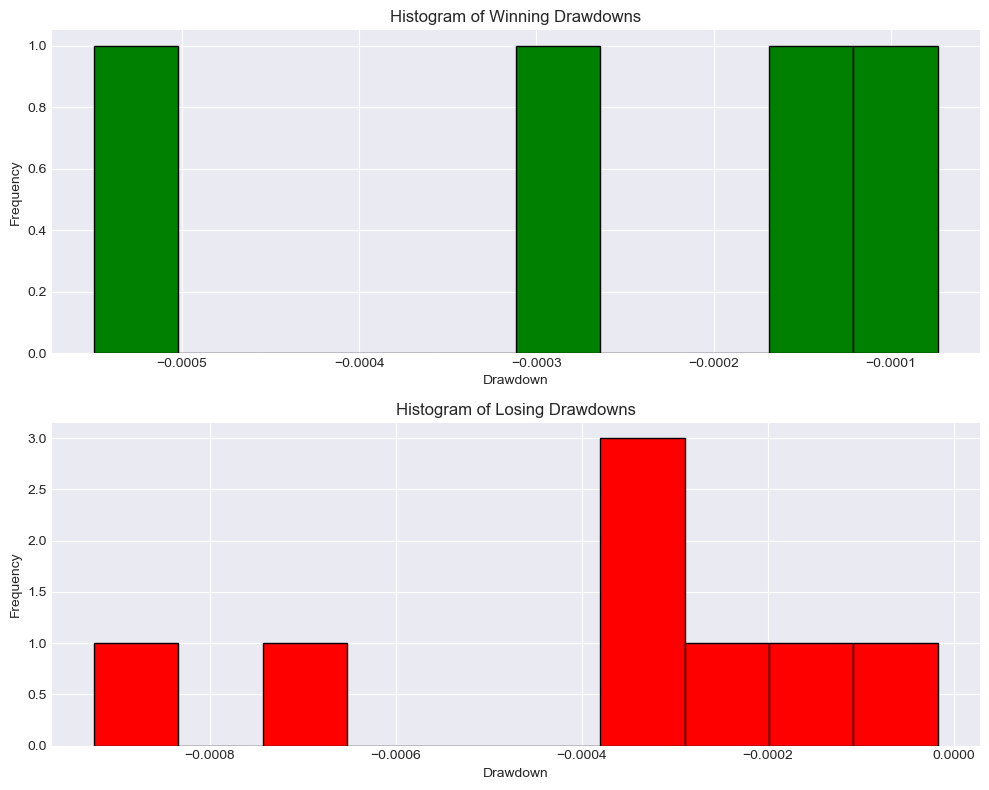

In [37]:
# Calculate maximum drawdowns and returns
drawdowns = []
returns = []
for entry, exit in zip(trade_entries, trade_exits):
    trade_data = data.loc[entry:exit, 'SPY']
    peak = trade_data.max()
    trough = trade_data.min()
    drawdown = (trough - peak) / peak
    trade_return = (trade_data.iloc[-1] - trade_data.iloc[0]) / trade_data.iloc[0]
    drawdowns.append(drawdown)
    returns.append(trade_return)

# Convert to DataFrame for easier analysis
trade_df = pd.DataFrame({
    'Drawdown': drawdowns,
    'Return': returns
})

# Separate winning and losing trades
winning_trades = trade_df[trade_df['Return'] > 0]
losing_trades = trade_df[trade_df['Return'] <= 0]

# Plot histograms of drawdowns
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].hist(winning_trades['Drawdown'], bins=10, edgecolor='k', color='green')
axs[0].set_title('Histogram of Winning Drawdowns')
axs[0].set_xlabel('Drawdown')
axs[0].set_ylabel('Frequency')

axs[1].hist(losing_trades['Drawdown'], bins=10, edgecolor='k', color='red')
axs[1].set_title('Histogram of Losing Drawdowns')
axs[1].set_xlabel('Drawdown')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show() 